In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Importo libreria para trabajar con dates
from datetime import timedelta

# Libreria para estimar regresión
import statsmodels.formula.api as sm

# Libreria para normalizar
from sklearn.preprocessing import StandardScaler

# Intentando predecir el precio de una acción dentro de un mes

## Primer paso: Descargar la data
<br>
Para hacerlo, usé la página de Yahoo Finanzas, busqué dos empresas que me interesaban analizar, y descargué el historial diario de precios y volúmenes del último año. <br>
<br>
En este caso, vamos a vincular el precio de acciones de Banco Santander y Banco Galicia. <br>
<br>
Página de descarga: 
<br>
https://es.finance.yahoo.com/quote/SAN.MC/history?p=SAN.MC
<br>

In [3]:
# Levanto la data descargada
url = "https://raw.githubusercontent.com/xlisouski/DataCoder/main/GGAL.csv"
galicia = pd.read_csv(url, sep=",")

url = "https://raw.githubusercontent.com/xlisouski/DataCoder/main/SAN.MC.csv"
santander = pd.read_csv(url, sep=",")

In [4]:
print(galicia.shape)
print(santander.shape)

(1677, 7)
(1723, 7)


In [5]:
galicia.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-25,33.060001,33.259998,31.760000,32.75,27.493952,640300
1,2017-01-26,32.509998,32.959999,31.780001,31.90,26.780361,197900
2,2017-01-27,31.639999,31.889999,31.059999,31.34,26.310238,299400
3,2017-01-30,30.920000,31.150000,30.660000,30.84,25.890488,284800
4,2017-01-31,30.610001,31.240000,30.610001,31.07,26.083569,446800


In [6]:
santander.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,4.638409,4.707217,4.636524,4.703447,3.601206,20481554.0
1,2017-01-03,4.712873,4.880651,4.709103,4.817499,3.688530,63383417.0
2,2017-01-04,4.838235,4.885364,4.789221,4.839178,3.705129,63903436.0
3,2017-01-05,4.829752,4.891962,4.802417,4.853316,3.715955,52036072.0
4,2017-01-06,4.840120,4.881594,4.811843,4.880651,3.736883,29360034.0


## Paso 2: definir qué estructura necesito 
<br>
Para construir un dataset analizable apuntando al objetivo para el cual estoy estudiando la data, primero necesito definir de manera concreta y objetiva qué quisiera hacer en este dataset. 
<br>
<br>

**Objetivo:** Predicir cuál será el precio de la acción al cierre del Banco Galicia exactamente dentro de 30 días. 
<br>

**Variable Target:** Precio de la acción del Banco Galicia dentro de 30 días. 
<br>

**Features:** Información relacionada al historial de precios tanto del Banco Galicia como del Banco Santander. 
<br>
<br>
#### Ejemplo puntual de cómo construir un renglón:
<br>

Si me paro en el 23/08/2023: 
<br>
1- El precio de la acción del Banco Galicia el 23/09/2023 será información para la variable target
<br>
2- El historial de precios y volúmenes antes del 23/08/2023 será información disponible para construir features 
<br>
<br>

**Entonces:** Muy importante conocer el concepto de **Punto de Observación**. 
Esto se refiere al momento del tiempo en que me estoy posicionando para construir el dataset de entrenamiento:

<br>

* La variable **Target** se calcula al momento del punto de observación o de manera posterior.
* Los **Features** siempre deben calcularse con anteioridad al punto de observación. **SIEMPRE**.

<br>

In [7]:
# Creo mi variable target
df = pd.DataFrame(galicia[["Date", "Close"]])
df.rename(columns={"Date": "Date_Target", "Close": "Close_Target"}, inplace=True)
df.head()

,Date_Target,Close_Target
0,2017-01-25,32.75
1,2017-01-26,31.90
2,2017-01-27,31.34
3,2017-01-30,30.84
4,2017-01-31,31.07


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date_Target   1677 non-null   object 
 1   Close_Target  1677 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.3+ KB


In [9]:
# Transformo en tipo de dato "datetime" y calculo la fecha de hace 30 dias
df["Date_Target"] = pd.to_datetime(df["Date_Target"])
df["Date_30dAntes"] = df["Date_Target"] - pd.DateOffset(days=30)
df.head()

,Date_Target,Close_Target,Date_30dAntes
0,2017-01-25,32.75,2016-12-26
1,2017-01-26,31.90,2016-12-27
2,2017-01-27,31.34,2016-12-28
3,2017-01-30,30.84,2016-12-31
4,2017-01-31,31.07,2017-01-01


In [10]:
# Empiezo a calcular features.
# Primero transformo las fechas de mi dataset en tipo dates:
galicia["Date"] = pd.to_datetime(galicia["Date"])
santander["Date"] = pd.to_datetime(santander["Date"])

In [11]:
# Primera: Precio de cierre y apertura hace 30 / 35 días:

# Definir el margen de tiempo de +/- 5 días
margen = timedelta(days=5)

# Realizar la unión basada en el margen de tiempo
df_entrenar = pd.merge_asof(
    df,
    galicia[["Date", "Close", "Open"]],
    left_on="Date_30dAntes",
    right_on="Date",
    direction="backward",
    tolerance=margen,
)

In [12]:
# Renonmbro features y printeo
df_entrenar.rename(
    columns={"Close": "Close_30dAntes", "Open": "Open_30dAntes"}, inplace=True
)
df_entrenar.head(100)

,Date_Target,Close_Target,Date_30dAntes,Date,Close_30dAntes,Open_30dAntes
0,2017-01-25,32.750000,2016-12-26,NaT,NaN,NaN
1,2017-01-26,31.900000,2016-12-27,NaT,NaN,NaN
2,2017-01-27,31.340000,2016-12-28,NaT,NaN,NaN
3,2017-01-30,30.840000,2016-12-31,NaT,NaN,NaN
4,2017-01-31,31.070000,2017-01-01,NaT,NaN,NaN
...,...,...,...,...,...,...
95,2017-06-12,42.369999,2017-05-13,2017-05-12,42.040001,42.669998
96,2017-06-13,42.180000,2017-05-14,2017-05-12,42.040001,42.669998
97,2017-06-14,41.799999,2017-05-15,2017-05-15,43.060001,42.180000
98,2017-06-15,41.759998,2017-05-16,2017-05-16,43.660000,43.250000


## Evaluemos valores vacíos 
<br>
Tenemos que preguntarnos, por qué hay valores vacíos? Vamos a inspeccionar: 

In [13]:
# Cuento vacíos
df_entrenar["Close_30dAntes"].isnull().value_counts()

Close_30dAntes
False    1656
True       21
Name: count, dtype: int64

In [14]:
# Cuento vacíos
df_entrenar["Open_30dAntes"].isnull().value_counts()

Open_30dAntes
False    1656
True       21
Name: count, dtype: int64

In [15]:
# Quienes son?
df_entrenar.loc[df_entrenar["Open_30dAntes"].isnull() == True,]

,Date_Target,Close_Target,Date_30dAntes,Date,Close_30dAntes,Open_30dAntes
0,2017-01-25,32.750000,2016-12-26,NaT,NaN,NaN
1,2017-01-26,31.900000,2016-12-27,NaT,NaN,NaN
2,2017-01-27,31.340000,2016-12-28,NaT,NaN,NaN
3,2017-01-30,30.840000,2016-12-31,NaT,NaN,NaN
4,2017-01-31,31.070000,2017-01-01,NaT,NaN,NaN
5,2017-02-01,31.350000,2017-01-02,NaT,NaN,NaN
6,2017-02-02,32.020000,2017-01-03,NaT,NaN,NaN
7,2017-02-03,32.360001,2017-01-04,NaT,NaN,NaN
8,2017-02-06,32.520000,2017-01-07,NaT,NaN,NaN
9,2017-02-07,33.220001,2017-01-08,NaT,NaN,NaN


Los valores vacíos que vemos son porque el target es lo más antiguo que tenía el dataset, cuando busco la data de hace un mes no existe en el dataset!
<br>

Lo que voy a hacer es dejarlos fuera del análisis, ya que no puedo calcular features para esas fechas. 

In [16]:
# Elimino registros con valores vacíos
df_entrenar = df_entrenar.dropna()
df_entrenar.shape

(1656, 6)

## Hay relación entre target y features creadas? 
<br>
Analicemos ahora si las features que generamos guardan relación con la variable target. 

/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Precio de la acción de Galicia')

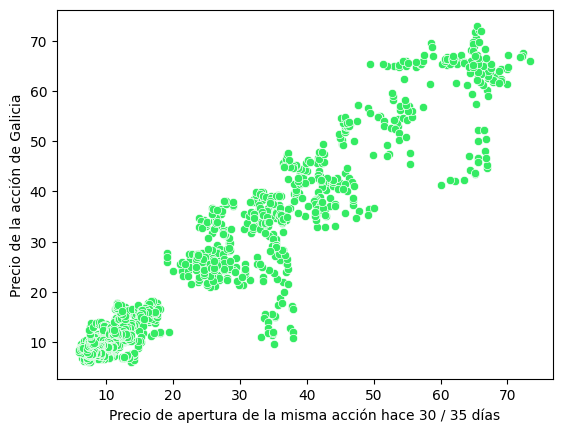

In [17]:
plt.figure()
sns.scatterplot(data=df_entrenar, x="Open_30dAntes", y="Close_Target", color="#34EB63")
plt.xlabel("Precio de apertura de la misma acción hace 30 / 35 días")
plt.ylabel("Precio de la acción de Galicia")

/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Precio de la acción de Galicia')

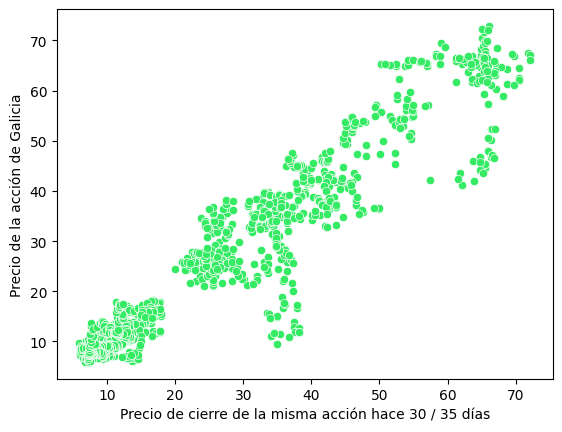

In [18]:
plt.figure()
sns.scatterplot(data=df_entrenar, x="Close_30dAntes", y="Close_Target", color="#34EB63")
plt.xlabel("Precio de cierre de la misma acción hace 30 / 35 días")
plt.ylabel("Precio de la acción de Galicia")

## Modelamos? 
Aparentemente hay una fuerte relación entre las features y la variable target. Modelamos? 

## Modelo 1: usando las dos features

In [19]:
# Estimo coeficientes para modelo de regresión lineal con una sola variable:
model1 = "Close_Target ~ Close_30dAntes + Open_30dAntes"
lm1 = sm.ols(formula=model1, data=df_entrenar).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:           Close_Target   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     9637.
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:02:50   Log-Likelihood:                -4955.6
No. Observations:                1656   AIC:                             9917.
Df Residuals:                    1653   BIC:                             9933.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.7001      0.193      3.

In [20]:
coeficientes = lm1.params
print("Coeficientes:")
print(coeficientes)

Coeficientes:
Intercept         0.700127
Close_30dAntes    0.901767
Open_30dAntes     0.055739
dtype: float64


In [21]:
intervalo_confianza = lm1.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(
    intervalo_confianza
)  # Se nos da vuelta el beta! Excluyamos la variable Open_30dAntes

Intervalo de confianza de los coeficientes:
                       0         1
Intercept       0.322334  1.077919
Close_30dAntes  0.607410  1.196123
Open_30dAntes  -0.238049  0.349527


In [22]:
pvalores = lm1.pvalues
print("P-Valores:")
print(pvalores.round(6))

P-Valores:
Intercept         0.000287
Close_30dAntes    0.000000
Open_30dAntes     0.709846
dtype: float64


In [23]:
r_cuadrado = lm1.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.921


## Modelo 2: Sin el precio de apertura

In [24]:
# Estimo coeficientes para modelo de regresión lineal con una sola variable:
model2 = "Close_Target ~ Close_30dAntes"
lm2 = sm.ols(formula=model2, data=df_entrenar).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:           Close_Target   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.928e+04
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:03:15   Log-Likelihood:                -4955.7
No. Observations:                1656   AIC:                             9915.
Df Residuals:                    1654   BIC:                             9926.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.7007      0.193      3.

In [25]:
coeficientes = lm2.params
print("Coeficientes:")
print(coeficientes)

Coeficientes:
Intercept         0.700721
Close_30dAntes    0.957555
dtype: float64


In [26]:
intervalo_confianza = lm2.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                      0         1
Intercept       0.32304  1.078402
Close_30dAntes  0.94403  0.971079


In [27]:
pvalores = lm2.pvalues
print("P-Valores:")
print(pvalores.round(6))

P-Valores:
Intercept         0.000282
Close_30dAntes    0.000000
dtype: float64


In [28]:
r_cuadrado = lm1.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.921


## Modelo 2 Visualmente

/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

Text(0.5, 1.0, 'Datos reales vs Estimación')

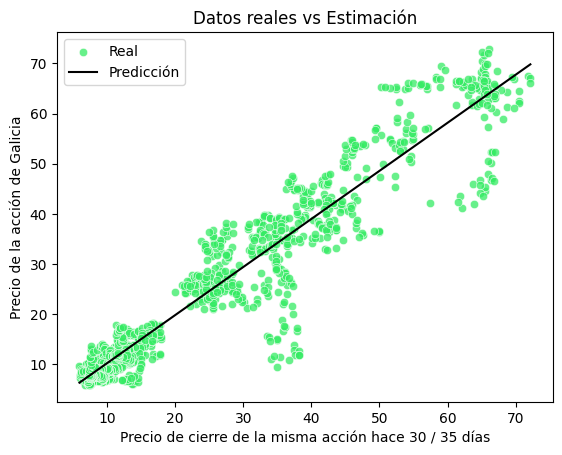

In [29]:
# Graficamente:
df_entrenar["y_estimado"] = lm2.predict(df_entrenar)
g1 = plt.figure()
sns.scatterplot(
    data=df_entrenar,
    x="Close_30dAntes",
    y="Close_Target",
    label="Real",
    color="#34EB63",
    alpha=0.75,
)
sns.lineplot(
    data=df_entrenar,
    x="Close_30dAntes",
    y="y_estimado",
    label="Predicción",
    color="black",
)
plt.xlabel("Precio de cierre de la misma acción hace 30 / 35 días")
plt.ylabel("Precio de la acción de Galicia")
plt.title("Datos reales vs Estimación")

# Agreguemos data de acciones de otro banco

In [30]:
# Segundo grupo: Precio de cierre y apertura de acciones de Santander hace 30 / 35 días:

# Definir el margen de tiempo de +/- 5 días
margen = timedelta(days=5)

# Realizar la unión basada en el margen de tiempo
df_entrenar = pd.merge_asof(
    df_entrenar,
    santander[["Date", "Close", "Open"]],
    left_on="Date_30dAntes",
    right_on="Date",
    direction="backward",
    tolerance=margen,
)
# Renonmbro features y printeo
df_entrenar.rename(
    columns={"Close": "CloseSantander_30dAntes", "Open": "OpenSantander_30dAntes"},
    inplace=True,
)
df_entrenar.head(100)

,Date_Target,Close_Target,Date_30dAntes,Date_x,Close_30dAntes,Open_30dAntes,y_estimado,Date_y,CloseSantander_30dAntes,OpenSantander_30dAntes
0,2017-02-24,32.570000,2017-01-25,2017-01-25,32.750000,33.060001,32.060632,2017-01-25,5.062568,4.967368
1,2017-02-27,32.299999,2017-01-28,2017-01-27,31.340000,31.639999,30.710480,2017-01-27,5.049372,5.062568
2,2017-02-28,31.799999,2017-01-29,2017-01-27,31.340000,31.639999,30.710480,2017-01-27,5.049372,5.062568
3,2017-03-01,32.910000,2017-01-30,2017-01-30,30.840000,30.920000,30.231702,2017-01-30,4.904215,4.995645
4,2017-03-02,32.570000,2017-01-31,2017-01-31,31.070000,30.610001,30.451940,2017-01-31,4.853316,4.901388
...,...,...,...,...,...,...,...,...,...,...
95,2017-07-12,42.680000,2017-06-12,2017-06-12,42.369999,43.040001,41.272305,2017-06-12,5.716715,5.731796
96,2017-07-13,41.689999,2017-06-13,2017-06-13,42.180000,42.400002,41.090371,2017-06-13,5.711059,5.749705
97,2017-07-14,40.910000,2017-06-14,2017-06-14,41.799999,42.299999,40.726499,2017-06-14,5.589467,5.725198
98,2017-07-17,39.959999,2017-06-17,2017-06-16,42.099998,41.669998,41.013764,2017-06-16,5.517832,5.575329


/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Precio de la acción de Galicia')

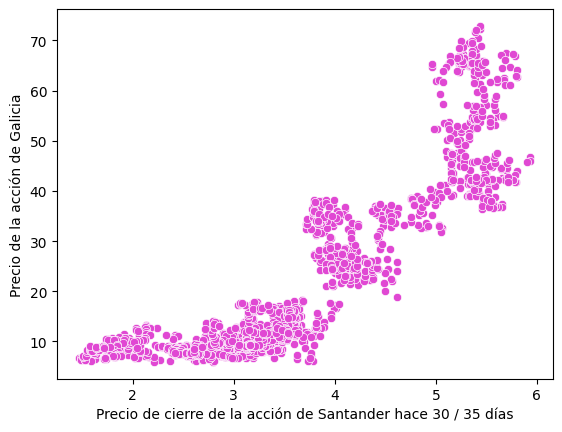

In [31]:
plt.figure()
sns.scatterplot(
    data=df_entrenar, x="CloseSantander_30dAntes", y="Close_Target", color="#E048D3"
)
plt.xlabel("Precio de cierre de la acción de Santander hace 30 / 35 días")
plt.ylabel("Precio de la acción de Galicia")

/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gerick/Coder/Data_Science/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Precio de la acción de Galicia')

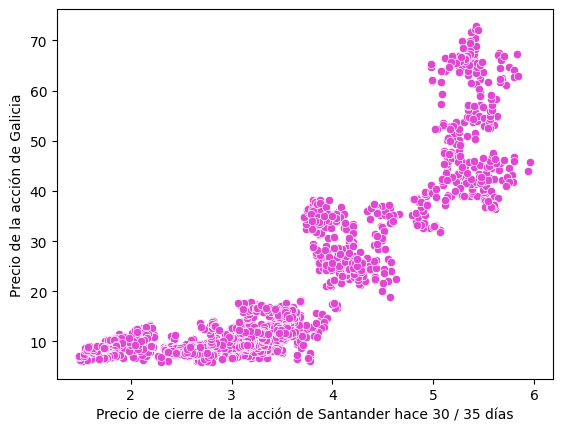

In [32]:
plt.figure()
sns.scatterplot(
    data=df_entrenar, x="OpenSantander_30dAntes", y="Close_Target", color="#E048D3"
)
plt.xlabel("Precio de cierre de la acción de Santander hace 30 / 35 días")
plt.ylabel("Precio de la acción de Galicia")

# Modelo 3: Incluyo precio de apertura de Santander

In [33]:
# Cuento vacíos
df_entrenar["CloseSantander_30dAntes"].isnull().value_counts()

CloseSantander_30dAntes
False    1656
Name: count, dtype: int64

In [34]:
# Estimo coeficientes para modelo de regresión lineal:
model3 = "Close_Target ~ Close_30dAntes + CloseSantander_30dAntes"
lm3 = sm.ols(formula=model3, data=df_entrenar).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:           Close_Target   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 1.030e+04
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:05:01   Log-Likelihood:                -4904.7
No. Observations:                1656   AIC:                             9815.
Df Residuals:                    1653   BIC:                             9832.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [35]:
intervalo_confianza = lm3.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                                0         1
Intercept               -5.831635 -3.628266
Close_30dAntes           0.802758  0.858037
CloseSantander_30dAntes  1.843754  2.716156


# Modelo 4: Normalizando los datos

In [36]:
scaler = StandardScaler()

# Selecciona las columnas numéricas que deseas escalar
columnas_a_escalar = ["Close_Target", "Close_30dAntes", "CloseSantander_30dAntes"]
sufijo = "_Norm"
columnas_a_escalar_nombres = [col + sufijo for col in columnas_a_escalar]
print(columnas_a_escalar_nombres)

['Close_Target_Norm', 'Close_30dAntes_Norm', 'CloseSantander_30dAntes_Norm']


In [37]:
# Aplica el método fit_transform a las columnas seleccionadas
df_entrenar[columnas_a_escalar_nombres] = scaler.fit_transform(
    df_entrenar[columnas_a_escalar]
)
df_entrenar.head()

,Date_Target,Close_Target,Date_30dAntes,Date_x,Close_30dAntes,Open_30dAntes,y_estimado,Date_y,CloseSantander_30dAntes,OpenSantander_30dAntes,Close_Target_Norm,Close_30dAntes_Norm,CloseSantander_30dAntes_Norm
0,2017-02-24,32.570000,2017-01-25,2017-01-25,32.75,33.060001,32.060632,2017-01-25,5.062568,4.967368,0.629558,0.625079,1.333793
1,2017-02-27,32.299999,2017-01-28,2017-01-27,31.34,31.639999,30.710480,2017-01-27,5.049372,5.062568,0.613828,0.543113,1.321687
2,2017-02-28,31.799999,2017-01-29,2017-01-27,31.34,31.639999,30.710480,2017-01-27,5.049372,5.062568,0.584697,0.543113,1.321687
3,2017-03-01,32.910000,2017-01-30,2017-01-30,30.84,30.920000,30.231702,2017-01-30,4.904215,4.995645,0.649368,0.514046,1.188514
4,2017-03-02,32.570000,2017-01-31,2017-01-31,31.07,30.610001,30.451940,2017-01-31,4.853316,4.901388,0.629558,0.527417,1.141817


In [38]:
# Estimo coeficientes para modelo de regresión lineal:
model4 = "Close_Target ~ Close_30dAntes_Norm + CloseSantander_30dAntes_Norm"
lm4 = sm.ols(formula=model4, data=df_entrenar).fit()
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:           Close_Target   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 1.030e+04
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:05:30   Log-Likelihood:                -4904.7
No. Observations:                1656   AIC:                             9815.
Df Residuals:                    1653   BIC:                             9832.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [39]:
intervalo_confianza = lm4.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                                      0          1
Intercept                     21.538671  21.990000
Close_30dAntes_Norm           13.809163  14.760071
CloseSantander_30dAntes_Norm   2.009673   2.960581
